In [3]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [4]:
import torch
from transformers import (
    AutoTokenizer
)

## Load tokenizer

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Load time series

In [6]:
from llmicl.rl_helpers.rl_utils import load_offline_dataset, create_env

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


In [7]:
env_name = 'HalfCheetah'
context_length = 400
dataset = 'expert'  # 'expert_80k_20k'
episode = 2

_, n_observations, n_actions = create_env(env_name)

data_path = f"/home/abenechehab/datasets/{env_name}/{dataset}/X_test.csv"
X = load_offline_dataset(path=data_path)

# find episodes beginnings
restart_index = n_observations+n_actions+1
restarts = X[:, restart_index]
episode_starts = np.where(restarts)[0]

print(f"episode starts: {episode_starts}")

init_index = episode_starts[episode]

time_series = X[init_index:init_index+context_length, :n_observations]

episode starts: [    0     1     2 ... 18997 18998 18999]


/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


# rescale + serialize

In [187]:
dim = 14
prediction_horizon = 50
tsr = X[init_index:init_index+context_length+prediction_horizon, dim]
normalized = (tsr-min(tsr))/(max(tsr)-min(tsr)) * 9.0 + 0.5
normalized_r = np.round(normalized, decimals=3)
normalized_str = ''
for i in range(context_length):
    normalized_str += str(int(normalized_r[i]*100))
    normalized_str += ','

In [9]:
X.shape

(19000, 27)

## Main code: call openai api

In [188]:
# !pip install -U openai
from openai import OpenAI
from transformers import AutoTokenizer

client = OpenAI(
    # base_url="http://10.155.97.225:4000/v1",
    base_url='http://10.227.91.60:4000/v1',  # For European Research Institue
    api_key="sk-1234",
)

chatgpt_sys_message = "You are a statistical and analytical assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence. The sequence is represented by decimal strings separated by commas."
extra_input = "Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the numbers. Sequence:\n"
# fibo_series = "1,1,2,3,5,8,13,21,34"

tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/"
    "62bd457b6fe961a42a631306577e622c83876cb6/",
    use_fast=False,
)

good_tokens_str = [","]
for num in range(1000):
    good_tokens_str.append(str(num))
good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]

predictions_llms = {}
for model in ["llama-3.1-70b-instruct",]:  # "llama-3-8b-instruct", ]:
    for prompt in [True, False]:
        # chat with llm
        stream = client.chat.completions.create(
            model=model,
            messages=[
                # {"role": "system", "content": chatgpt_sys_message},
                {"role": "user", "content": extra_input + normalized_str[:-1] if prompt else normalized_str[:-1]},
                # {"role": "user", "content": normalized_str[:-1]},
            ],
            temperature=0,
            stream=True,
            max_tokens=prediction_horizon*2-1,
            logit_bias={id: 100 for id in good_tokens},
        )
        
        full_response = ''
        for chunk in stream:
            try:
                full_response += chunk.choices[0].delta.content
                # full_response += ','
            except TypeError:
                pass
        print(f"raw response: {full_response}\n")
        key = model + "+prompt" if prompt else model
        predictions_llms[key] = np.array([int(e)/100 for e in full_response.split(',') if e != ''])
        print(f"model: {key}\n full_response: {predictions_llms[key]}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


raw response: 667,555,446,83,504,882,623,555,446,74,504,882,623,555,446,83,504,882,623,555,446,74,504,882,623,555,446,83,504,882,623,555,446,74,504,882,623,555,446,83,504,882,623,555,446,74,504,882,623,555

model: llama-3.1-70b-instruct+prompt
 full_response: [6.67 5.55 4.46 0.83 5.04 8.82 6.23 5.55 4.46 0.74 5.04 8.82 6.23 5.55
 4.46 0.83 5.04 8.82 6.23 5.55 4.46 0.74 5.04 8.82 6.23 5.55 4.46 0.83
 5.04 8.82 6.23 5.55 4.46 0.74 5.04 8.82 6.23 5.55 4.46 0.83 5.04 8.82
 6.23 5.55 4.46 0.74 5.04 8.82 6.23 5.55]
raw response: 553,571,310,293,506,562,653,654,443,311,383,511,503,606,616,663,449,252,313,567,567,563,687,595,599,439,332,254,490,735,616,536,333,281,475,551,611,629,633,380,344,359,542,691,505,700,371,216,375,600

model: llama-3.1-70b-instruct
 full_response: [5.53 5.71 3.1  2.93 5.06 5.62 6.53 6.54 4.43 3.11 3.83 5.11 5.03 6.06
 6.16 6.63 4.49 2.52 3.13 5.67 5.67 5.63 6.87 5.95 5.99 4.39 3.32 2.54
 4.9  7.35 6.16 5.36 3.33 2.81 4.75 5.51 6.11 6.29 6.33 3.8  3.44 3.59
 5.42 6.91 

## Visualization

llama-3.1-70b-instruct+prompt
llama-3.1-70b-instruct


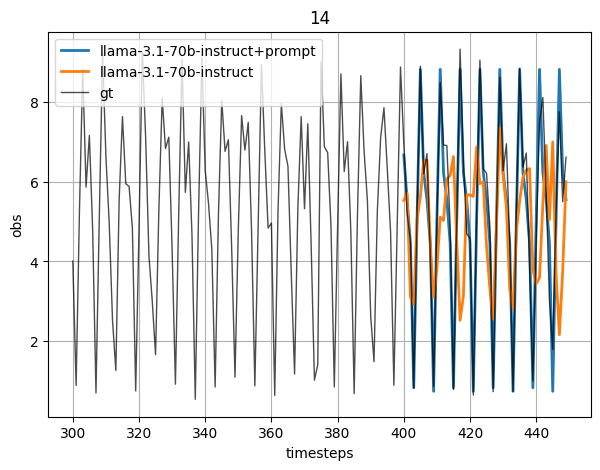

In [189]:
start_from = 300
f, axes = plt.subplots(1, 1, figsize=(7, 5), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
ax = axes[0]

# -------------------- Trajectory visualization --------------------
x = np.arange(len(normalized_r))
# multi_step
for model in predictions_llms.keys():
    print(model)
    if -prediction_horizon+len(predictions_llms[model]) != 0:
        ax.plot(
            x[-prediction_horizon:-prediction_horizon+len(predictions_llms[model])], 
            predictions_llms[model], 
            label=model,
            linewidth=2
        )
    else:
        ax.plot(x[-prediction_horizon:], predictions_llms[model], label=model, linewidth=2)

ax.plot(x[start_from:], normalized_r[start_from:], label='gt', color='black', alpha=.7, linewidth=1)
ax.set_title(f"{dim}")
ax.set_xlabel("timesteps")
ax.set_ylabel("obs")

ax.legend()
# f.suptitle(f'Halfcheetah - expert policy', y=-1.1)
# plt.savefig(f"multi_step_halfcheetah_expert.png")
ax.grid(True)
plt.show()

# The tabular approach

In [14]:
state_names = {
    "HalfCheetah": [
        "rootx",
        "rootz",
        "rooty",
        "bthigh",
        "bshin",
        "bfoot",
        "fthigh",
        "fshin",
        "ffoot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "bthigh_dot",
        "bshin_dot",
        "bfoot_dot",
        "fthigh_dot",
        "fshin_dot",
        "ffoot_dot",
    ],
    "Hopper": [
        "rootx",
        "rootz",
        "rooty",
        "thigh",
        "leg",
        "foot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_dot",
        "leg_dot",
        "foot_dot",
    ]
}
action_names = {
    "HalfCheetah": [
        "t_bthigh",
        "t_bshin",
        "t_bfoot",
        "t_fthigh",
        "t_fshin",
        "t_ffoot",
    ],
    "Hopper": [
        "thigh_joint",
        "leg_joint",
        "foot_joint",
    ]
}

## Prompt template

In [15]:
# From the paper: Prompt a Robot to Walk with Large Language Models
prompt_system = '''
    You are the controller of a quadrupedal robot (A1 robot) with 10 Hz.
    Please inference the output.
    
    The robot's state is represented by a 33-dimensional input space.
    The first 3 dimensions correspond to the robot's linear velocity.
    The next 3 dimensions denote the robot's angular velocity.
    The following 3 dimensions represent the gravity vector.
    The subsequent 12 dimensions represent the joint positions.
    The final 12 dimensions indicate the velocity of each joint.

    The output space is 12-dimension, which is the joint position. 
    
    The order of the joints is [FRH, FRT, FRC, FLH, FLT, FLC, RRH, RRT, RRC, RLH, RLT, RLC].

    After we have the output, we will use 200 Hz PD controller to track it.

    The following are past and consecutive inputs and outputs.
    All numbers are normalized to non-negative integers by our special rule. 
    The output would be impacted by the previous inputs.
    The trend of the outputs should be smooth.

    Your output is only one line and starts with "Output:", please do not output any words.
    
    '''

In [45]:
def build_prompt(env_name, data, n_examples: int = 9):
    # by Mistral LArge 2
    prompt_mistral = f'''
    You are a dynamics learner tasked with generating the next state in a Markov Decision Process (MDP) for the {env_name} environment based on the Mujoco physics simulator and the Gym library.
    
    State Dimensions:
    
    rootz: z-coordinate of the front tip (position in meters)
    rooty: angle of the front tip (angle in radians)
    bthigh: angle of the second rotor (bthigh, angle in radians)
    bshin: angle of the second rotor (bshin, angle in radians)
    bfoot: angle of the second rotor (bfoot, angle in radians)
    fthigh: angle of the second rotor (fthigh, angle in radians)
    fshin: angle of the second rotor (fshin, angle in radians)
    ffoot: angle of the second rotor (ffoot, angle in radians)
    rootx_dot: x-coordinate of the front tip (velocity in meters/second)
    rootz_dot: y-coordinate of the front tip (velocity in meters/second)
    rooty_dot: angular velocity of the front tip (angular velocity in radians/second)
    bthigh_dot: angular velocity of the second rotor (bthigh, angular velocity in radians/second)
    bshin_dot: angular velocity of the second rotor (bshin, angular velocity in radians/second)
    bfoot_dot: angular velocity of the second rotor (bfoot, angular velocity in radians/second)
    fthigh_dot: angular velocity of the second rotor (fthigh, angular velocity in radians/second)
    fshin_dot: angular velocity of the second rotor (fshin, angular velocity in radians/second)
    ffoot_dot: angular velocity of the second rotor (ffoot, angular velocity in radians/second)
    
    Action Dimensions:
    
    t_bthigh: Torque applied on the back thigh rotor (torque in N m, range: -1 to 1)
    t_bshin: Torque applied on the back shin rotor (torque in N m, range: -1 to 1)
    t_bfoot: Torque applied on the back foot rotor (torque in N m, range: -1 to 1)
    t_fthigh: Torque applied on the front thigh rotor (torque in N m, range: -1 to 1)
    t_fshin: Torque applied on the front shin rotor (torque in N m, range: -1 to 1)
    t_ffoot: Torque applied on the front foot rotor (torque in N m, range: -1 to 1)

    The following are past and consecutive inputs and outputs.
    The output would be impacted by the previous inputs.
    The trend of the outputs should be smooth.

    Your output is only one line and starts with "Output:", please do not output any words.
    '''

    # process data and add examples in the following format:
    '''
    Input: [x: 0.5, y: 0.0, z: 0.5, vx: 0.1, vy: 0.0, vz: 0.0, angle1: 0.5, angle2: 1.0, angle3: 0.2, angle4: 0.3, angle5: 0.4, angle6: 0.1, vel1: 0.1, vel2: 0.2, vel3: 0.3, vel4: 0.4, vel5: 0.5, vel6: 0.6, action1: 0.5, action2: 1.0, action3: 0.2, action4: 0.3, action5: 0.4, action6: 0.1]
    Output: [x: 0.55, y: 0.0, z: 0.5, vx: 0.11, vy: 0.0, vz: 0.0, angle1: 0.55, angle2: 1.1, angle3: 0.22, angle4: 0.33, angle5: 0.44, angle6: 0.11, vel1: 0.11, vel2: 0.22, vel3: 0.33, vel4: 0.44, vel5: 0.55, vel6: 0.66]
    
    Input: [x: 0.3, y: 0.0, z: 0.3, vx: 0.05, vy: 0.0, vz: 0.0, angle1: 0.3, angle2: 0.8, angle3: 0.1, angle4: 0.2, angle5: 0.3, angle6: 0.05, vel1: 0.05, vel2: 0.1, vel3: 0.15, vel4: 0.2, vel5: 0.25, vel6: 0.3, action1: 0.3, action2: 0.8, action3: 0.1, action4: 0.2, action5: 0.3, action6: 0.05]
    Output: [x: 0.33, y: 0.0, z: 0.3, vx: 0.06, vy: 0.0, vz: 0.0, angle1: 0.33, angle2: 0.88, angle3: 0.11, angle4: 0.22, angle5: 0.33, angle6: 0.06, vel1: 0.06, vel2: 0.11, vel3: 0.16, vel4: 0.22, vel5: 0.26, vel6: 0.33]
    
    New Test Point:
    
    Input: [x: 0.4, y: 0.0, z: 0.4, vx: 0.08, vy: 0.0, vz: 0.0, angle1: 0.4, angle2: 0.9, angle3: 0.15, angle4: 0.25, angle5: 0.35, angle6: 0.08, vel1: 0.08, vel2: 0.15, vel3: 0.2, vel4: 0.25, vel5: 0.3, vel6: 0.35, action1: 0.4, action2: 0.9, action3: 0.15, action4: 0.25, action5: 0.35, action6: 0.08]
    '''
    
    for t in range(n_examples):
        if t < n_examples-1:
            example_str = f'''
            Example {t+1}
            
            Input: ['''
            for dim in range(n_observations+n_actions):
                if dim < n_observations:
                    example_str += state_names[env_name][dim]
                else:
                    # print(f"dim: {dim}, dim-n_observations: {dim-n_observations}")
                    example_str += action_names[env_name][dim-n_observations]
                example_str += ': ' + f'{data[t, dim]:.4f}' + ', '
            example_str += ''']
        
            Output: ['''
            for dim in range(n_observations):
                example_str += state_names[env_name][dim]
                example_str += ': ' + f'{data[t+1, dim]:.4f}' + ', '    
            example_str += ']\n'
        else:
            example_str = f'''
            New Test Point:
            
            Input: ['''
            for dim in range(n_observations+n_actions):
                if dim < n_observations:
                    example_str += state_names[env_name][dim]
                else:
                    # print(f"dim: {dim}, dim-n_observations: {dim-n_observations}")
                    example_str += action_names[env_name][dim-n_observations]
                example_str += ': ' + f'{data[t, dim]:.4f}' + ', '
            example_str += ']\n'
        prompt_mistral += example_str
    
    return prompt_mistral

In [48]:
prompt = build_prompt(env_name=env_name, data=X[init_index:init_index+13], n_examples=12)
print(prompt)


    You are a dynamics learner tasked with generating the next state in a Markov Decision Process (MDP) for the HalfCheetah environment based on the Mujoco physics simulator and the Gym library.
    
    State Dimensions:
    
    rootz: z-coordinate of the front tip (position in meters)
    rooty: angle of the front tip (angle in radians)
    bthigh: angle of the second rotor (bthigh, angle in radians)
    bshin: angle of the second rotor (bshin, angle in radians)
    bfoot: angle of the second rotor (bfoot, angle in radians)
    fthigh: angle of the second rotor (fthigh, angle in radians)
    fshin: angle of the second rotor (fshin, angle in radians)
    ffoot: angle of the second rotor (ffoot, angle in radians)
    rootx_dot: x-coordinate of the front tip (velocity in meters/second)
    rootz_dot: y-coordinate of the front tip (velocity in meters/second)
    rooty_dot: angular velocity of the front tip (angular velocity in radians/second)
    bthigh_dot: angular velocity of the sec

In [29]:
print('t \n u')

t 
 u
